In [1]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [2]:
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

arxiv_wrapper = ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper = WikipediaAPIWrapper(top_k_results=1,doc_content_CHARS_MAX=300)
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

In [3]:
tools=[arxiv_tool,wiki_tool]

In [4]:
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list,add_messages]

In [5]:
from langgraph.graph import StateGraph, START, END
graph_builder = StateGraph(State)

In [6]:
tools=[wiki_tool,arxiv_tool]

In [7]:
import os
from langchain_groq import ChatGroq
groq_api_key=os.environ.get("groq_api_key")

llm =ChatGroq(groq_api_key=groq_api_key)

In [8]:
llm.invoke("Hey").content

"Hello! How can I help you today? If you have any questions about Python or programming in general, feel free to ask. I'm here to assist you."

In [9]:
llm_with_tools=llm.bind_tools(tools)

In [10]:
def chatbot(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node("chatbot",chatbot)
tool_node=ToolNode(tools=tools)

In [11]:
graph_builder.add_node("tools",tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

In [12]:
graph_builder.add_edge("tools","chatbot")
graph_builder.add_edge(START,"chatbot")
graph_builder.add_edge("chatbot",END)

In [13]:
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ tools, if desired.
    # interrupt_after=["tools"]
)

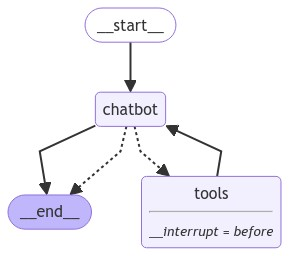

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [15]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_36y4)
 Call ID: call_36y4
  Args:
    query: LangGraph


In [16]:
snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_36y4)
 Call ID: call_36y4
  Args:
    query: LangGraph


In [17]:
from langchain_core.messages import AIMessage, ToolMessage

answer = (
    "LangGraph is a library for building stateful, multi-actor applications with LLMs."
)
new_messages = [
    # The LLM API expects some ToolMessage to match its tool call. We'll satisfy that here.
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]["id"]),
    # And then directly "put words in the LLM's mouth" by populating its response.
    AIMessage(content=answer),
]

new_messages[-1].pretty_print()
graph.update_state(
    # Which state to update
    config,
    # The updated values to provide. The messages in our `State` are "append-only", meaning this will be appended
    # to the existing state. We will review how to update existing messages in the next section!
    {"messages": new_messages},
)

print("\n\nLast 2 messages;")
print(graph.get_state(config).values["messages"][-2:])

================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.


Last 2 messages;
[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='0b44e8e2-e949-46aa-96f3-63d6a8435758', tool_call_id='call_36y4'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='46897ee3-07d6-41a0-abe2-4744daa85a2c')]


In [18]:
graph.update_state(
    config,
    {"messages": [AIMessage(content="I'm an AI expert!")]},
    # Which node for this function to act as. It will automatically continue
    # processing as if this node just ran.
    as_node="chatbot",
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef6871b-8c6b-6787-8003-d49dae3e311d'}}

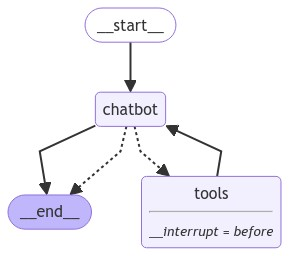

In [19]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [20]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "2"}}  # we'll use thread_id = 2 here
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_vgrj)
 Call ID: call_vgrj
  Args:
    query: LangGraph
